KMPG Data Assessment 

In [7]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import geopandas as gpd
from shapely.geometry import Point

In [8]:
# Importing in Dataset (Part 1 - Task 1)
HotelData = pd.read_csv('hotels.csv')

In [61]:
# HotelData.groupby('reviewer_score')['reviewer_score'].count().sort_values(ascending = False).reset_index(name = 'Frequency')
# Q1 = HotelData.groupby('hotel_name')['reviewer_score'].quantile(0.25)
# Q3 = HotelData.groupby('hotel_name')['reviewer_score'].quantile(0.75)
# IQR = Q3 - Q1
# IQR = IQR.sort_values(ascending = False).reset_index(name = 'IQR').iloc[0:10,:]
# IQR
hi = (np.where(HotelData['reviewer_score'] > 9))
len(hi[0]) / len(HotelData)


0.47774257471817083

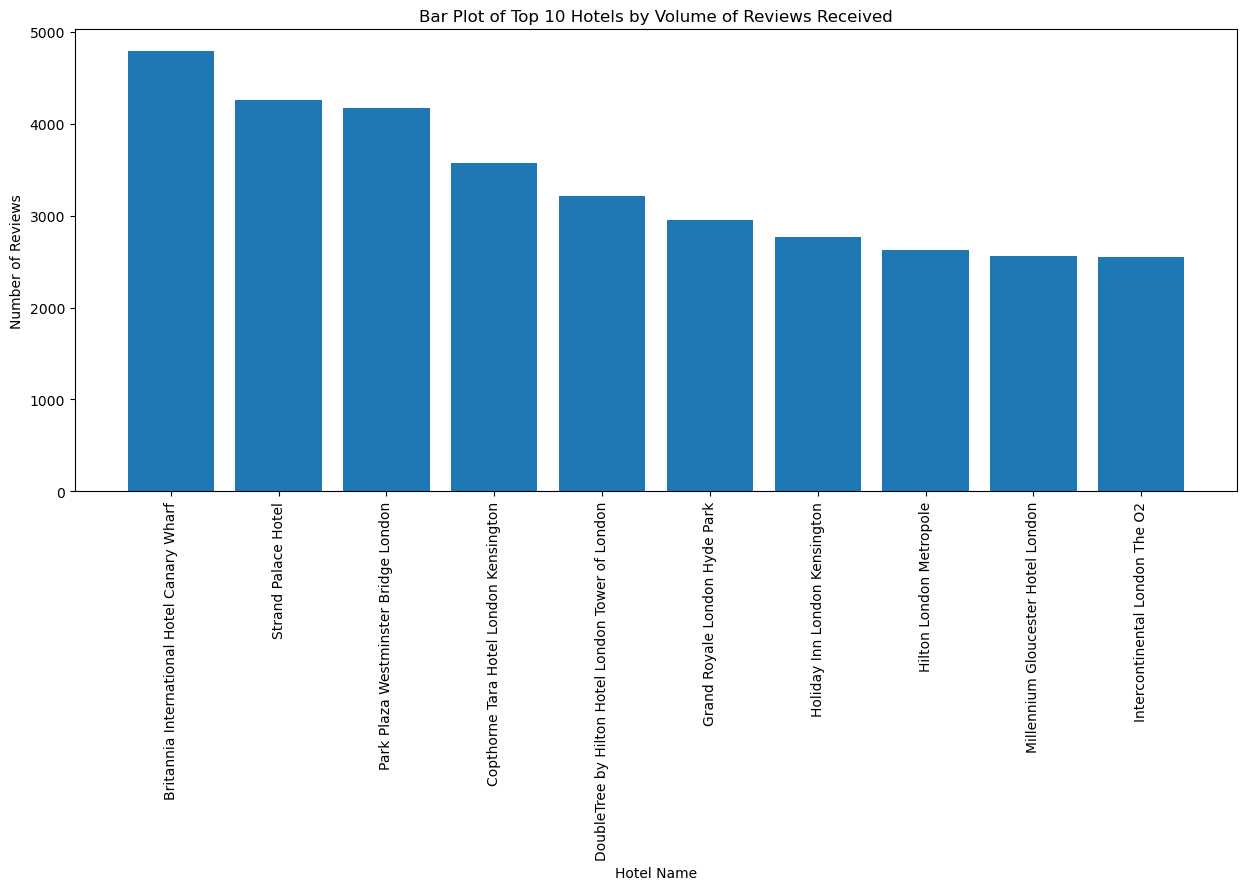

In [504]:
#Exploratory Plots (Part 1 - Task 2)
HotelReviewCount = HotelData.groupby('hotel_name')['hotel_name'].count().reset_index(name = 'review_count').sort_values(ascending = False, by = 'review_count').iloc[0:10]

#Plot code
fig = plt.figure(figsize=(15, 6))
plt.bar(x = HotelReviewCount['hotel_name'], height=HotelReviewCount['review_count'], width = 0.8)
plt.xlabel('Hotel Name')
plt.ylabel('Number of Reviews')
plt.title('Bar Plot of Top 10 Hotels by Volume of Reviews Received')
plt.xticks(rotation=90)

plt.show()

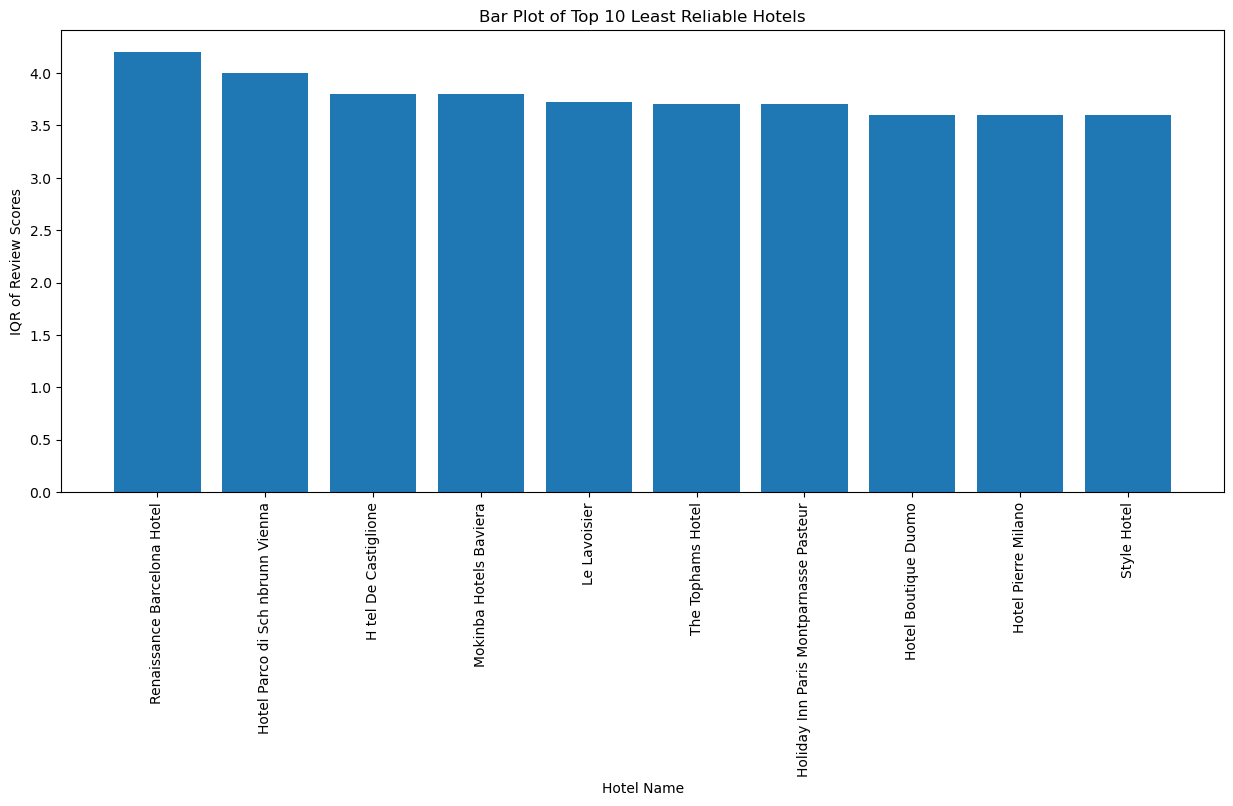

In [523]:
#Exploratory Plots (Part 1 - Task 2)
Q1 = HotelData.groupby(["hotel_name"])["reviewer_score"].quantile(0.25).reset_index(name="Q1")
Q3 =  HotelData.groupby(["hotel_name"])["reviewer_score"].quantile(0.75).reset_index(name="Q3")

hotel_score_ranges = pd.merge(Q1,Q3,how='inner',on='hotel_name')
hotel_score_ranges["IQR"] = hotel_score_ranges["Q3"] - hotel_score_ranges["Q1"]
hotel_score_ranges = hotel_score_ranges.sort_values(ascending = False, by = 'IQR').iloc[0:10]

#Plot code
fig = plt.figure(figsize=(15, 6))
plt.bar(x = hotel_score_ranges['hotel_name'], height=hotel_score_ranges['IQR'], width = 0.8)
plt.xlabel('Hotel Name')
plt.ylabel('IQR of Review Scores')
plt.title('Bar Plot of Top 10 Least Reliable Hotels')
plt.xticks(rotation=90)

plt.show()

In [4]:
#Postive Review WordCount (Part 1 - Task 3)
PosReviewWCList = []

#Set of commonly occuring stopwords
StopWords = list(stopwords.words("english"))
StopWords.extend(['', ''])

#Iterate through the positive reviews and calculating the word count of each positive review
for i in range (len(HotelData)):
    PosReview = HotelData['positive_review'][i].split(' ')
    #Deleting all occurences of stopwords in dictionary
    PosReview = [stopword for stopword in PosReview if stopword not in StopWords]
    if (len(PosReview) >= 2):
        if ((PosReview[0] == 'No') & (PosReview[1] == 'Positive')):
            PosReviewWCList.append(0)
        else:
            PosReviewWCList.append(len(PosReview))
    else:
        PosReviewWCList.append(len(PosReview)) 
HotelData['positive_review_wc'] = PosReviewWCList

#Negative Review WordCount (Part 2) - Feature Addition
NegReviewWCList = []

#Iterate through the negative reviews and calculating the word count of each negative review
for i in range (len(HotelData)):
    NegReview = HotelData['negative_review'][i].split(' ')
    #Deleting all occurences of stopwords in dictionary
    NegReview = [stopword for stopword in NegReview if stopword not in StopWords]
    if (len(NegReview) >= 2):
        if ((NegReview[0] == 'No') & (NegReview[1] == 'Negative')):
            NegReviewWCList.append(0)
        else:
            NegReviewWCList.append(len(NegReview))
    else:
        NegReviewWCList.append(len(NegReview))
HotelData['negative_review_wc'] = NegReviewWCList

KeyboardInterrupt: 

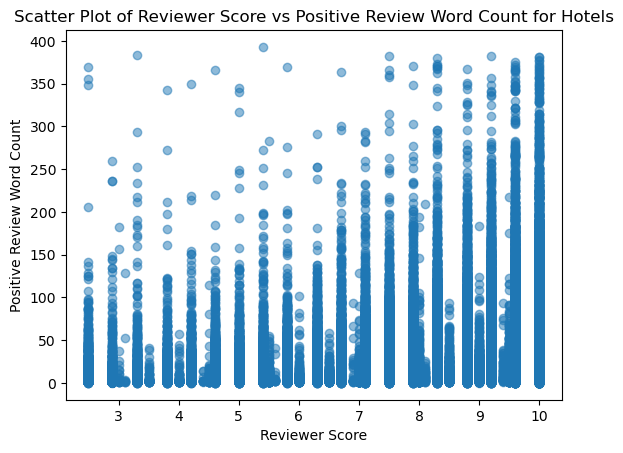

In [84]:
#Postive Review WordCount vs Reviewer Score Scatter Plot (Part 1 - Task 4)
plt.scatter(HotelData['reviewer_score'], HotelData['positive_review_wc'], alpha = 0.5, )
plt.xlabel('Reviewer Score')
plt.ylabel('Positive Review Word Count')
plt.title('Scatter Plot of Reviewer Score vs Positive Review Word Count for Hotels')
plt.show()

In [5]:
#Obtaining 10 most frequently used words in positive reviews made (Part 1 - Task 4)
WordList = []

#Set of commonly occuring stopwords
StopWords = list(stopwords.words("english"))
StopWords.extend(['', ''])

#Comply a list of the counts of each unique word in positive reviews
for i in range (len(HotelData)):
    WordList.append(HotelData['positive_review'][i].split(' '))
WordList = [item for sublist in WordList for item in sublist]


#Converts all words to lower case for string matching deviations on the same words
WordList = [s.lower() for s in WordList]

#Removing stopwords
WordList = [stopword for stopword in WordList if stopword not in StopWords]
        
WordOccurrences = {}
for word in WordList:
    if word in WordOccurrences:
        # If the word is already in the dictionary, increment its count by 1
        WordOccurrences[word] += 1
    else:
        # If the word is not in the dictionary, add it with a count of 1
        WordOccurrences[word] = 1

# Sort the dictionary by values in descending order
SortedWordOccurrences = dict(sorted(WordOccurrences.items(), key=lambda item: item[1], reverse=True))

#Getting top 10 
Best10_SortedWordOccurrences = OrderedDict(list(SortedWordOccurrences.items())[:10])


Logistic Regression Model

In [355]:
#Dropping features function
def DropFeature(X, X_test, FeaturesDrop):
    return (X.drop(columns = FeaturesDrop)), (X_test.drop(columns = FeaturesDrop))

In [356]:
#Creating new features for day, month and year 
def TimeFeature(X, X_test):
    X['review_date'] = pd.to_datetime(X['review_date'])
    X['day'] = X['review_date'].dt.day
    X['month'] = X['review_date'].dt.month
    X['year'] = X['review_date'].dt.year
    # X = DropFeature(X, 'review_date')

    X_test['review_date'] = pd.to_datetime(X_test['review_date'])
    X_test['day'] = X_test['review_date'].dt.day
    X_test['month'] = X_test['review_date'].dt.month
    X_test['year'] = X_test['review_date'].dt.year
    # X_test = DropFeature(X_test, 'review_date')

    return X, X_test

In [357]:
# Helper func
def split_list(input_list, step, start_index):
    output_list = []
    for i in range(start_index, len(input_list), step):
        output_list.append(input_list[i])
    return output_list

    # Helper func
def search_and_append(list1, list2):
    result = []
    for item1 in list1:
        if item1 in list2:
            result.append(1)
        else:
            result.append(0)
    return result  

In [358]:
# One-hot encoding tag feature by only selecting the most populated classes
def TagFeature(X, n):
    balancing_row = n
    #Processing 'tags' string formatting
    stringremoval = ['[', ']', ' ', ',', ', ', ' ,']
    unique_list = []

    for i in range (len(X)):
        stringtag = (X['tags'][i]).split("'")
        stringtagprocessed = [x for x in stringtag if x not in stringremoval]
        unique_list.append(stringtagprocessed)
    unique_list_tags = [element for sublist in unique_list for element in sublist]
    unique_list_tags_features = set(unique_list_tags)

    # Use list comprehensions to count occurrences
    occurrences = [unique_list_tags.count(value) for value in unique_list_tags_features]
    # Create a dictionary mapping unique values to their occurrences
    occurrences_dict = dict(zip(unique_list_tags_features, occurrences))
    sorted_occurrences = dict(sorted(occurrences_dict.items(), key=lambda x: x[1], reverse=True))

    sorted_occurrences_tags = pd.DataFrame(list(sorted_occurrences.items()), columns=['Key', 'Value'])
    sorted_occurrences_tags.columns = ['Key', 'Value']
    
    Tags = sorted_occurrences_tags.iloc[0:balancing_row,:]
    unique_tags = (Tags['Key']).unique()

    return unique_tags, sorted_occurrences_tags, Tags, unique_list_tags_features, unique_list, unique_list_tags, tags, tags_test
 

In [359]:
def EditTagFeature (X, X_test, n):
    tags, tags_test = [], []

    X = X.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    
    unique_tags, sorted_occurrences_tags, Tags, unique_list_tags_features, unique_list, unique_list_tags,  tags, tags_test = TagFeature(X,n)
    unique_tags_test, sorted_occurrences_tags_test, Tags_test, unique_list_tags_features_test, unique_list_test, unique_list_tags_test, tags, tags_test = TagFeature(X_test,n)

    for i in range (len(X)):
        result = search_and_append(unique_tags, [(X['tags'][i])])
        tags.append(result)
    for i in range (len(X_test)):
        result = search_and_append(unique_tags_test, [(X_test['tags'][i])])
        tags_test.append(result)

    X = pd.concat([X, Tags], axis = 1)
    X_test = pd.concat([X_test, Tags_test], axis = 1)

    return X, X_test

In [360]:
def HotelNameFeature(X,n):

    balancing_row = n

    occurrences = [(list(X['hotel_name'])).count(value) for value in ((X['hotel_name']).unique())]
    occurrences_dict = dict(zip(((X['hotel_name']).unique()), occurrences))

    sorted_occurrences = dict(sorted(occurrences_dict.items(), key=lambda x: x[1], reverse=True))
    sorted_occurrences_tags = pd.DataFrame(list(sorted_occurrences.items()), columns=['Key', 'Value'])
    sorted_occurrences_tags.columns = ['Key', 'Value']

    names = sorted_occurrences_tags.iloc[0:balancing_row,:]

    unique_names = (names['Key']).unique()

    return unique_names, names, sorted_occurrences_tags, occurrences_dict, occurrences

In [361]:
def EditHotelNameFeature(X, X_test, n):
    names, names_test = [], []
    
    X = X.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

    unique_names, names, sorted_occurrences_tags, occurrences_dict, occurrences = HotelNameFeature(X, n)
    unique_names_test, names_test, sorted_occurrences_tags_test, occurrences_dict_test, occurrences_test = HotelNameFeature(X_test, n)

    for i in range (len(X)):
        result = search_and_append(unique_names, [(X['hotel_name'][i])])
        names.append(result)
    for i in range (len(X_test)):
        result = search_and_append(unique_names_test, [(X_test['hotel_name'][i])])
        names_test.append(result)
    
    Names = pd.DataFrame(data = names, column = [x for x in unique_names])
    Names_test = pd.DataFrame(data = names_test, column = [x for x in unique_names_test])

    X = pd.concat([X, Names], axis = 1)
    X_test = pd.concat([X_test, Names_test], axis = 1)

    return X, X_test

In [468]:
def SentimentScoreFeature(X, X_test, text_column, analyzer):

    def score_sentiment(review):
        sentiment_scores = analyzer.polarity_scores(review)
        return sentiment_scores

    # Apply the sentiment scoring function to the text_column in the DataFrame
    X['sentiment_scores'] = X[text_column].apply(score_sentiment)
    X_test['sentiment_scores'] = X_test[text_column].apply(score_sentiment)

    X['compound'] = X['sentiment_scores'].apply(lambda x: x['compound'])
    X_test['compound'] = X_test['sentiment_scores'].apply(lambda x: x['compound'])

    X, X_test = DropFeature(X, X_test, ['sentiment_scores'])

    return X, X_test

In [480]:
def ReviewDaysFeature(X, X_test):
    X['days_since_review'] = X['days_since_review'].str.split(' ').str.get(0)
    X_test['days_since_review'] = X_test['days_since_review'].str.split(' ').str.get(0)
    return X, X_test

In [485]:
def CrossValidation ():
    pass

In [482]:
#Fitting Classification Model (Part 2 - Option 1)
# Feature Engineering

X = HotelData.drop('reviewer_score', axis=1)
y = HotelData['reviewer_score']
X, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n = 1

#Label imbalance test
binary_y_label = np.where((HotelData['reviewer_score']) > 9, 1, 0)
proportion_1s = np.mean(binary_y_label)
proportion_0s = 1 - proportion_1s
print("Proportion of scores greater than 9: ", proportion_1s)
print("Proportion of scores less than or equal to 9: ", proportion_0s)

#Feature Modifications
X, X_test = ReviewDaysFeature(X, X_test)
X, X_test = TimeFeature(X, X_test)
# X, X_test = EditTagFeature (X, X_test, n)
# X, X_test = EditHotelNameFeature (X, X_test, n)

# Create an instance of the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
X, X_test = SentimentScoreFeature(X, X_test, 'positive_review', analyzer)
X, X_test = SentimentScoreFeature(X, X_test, 'negative_review', analyzer)

FeaturesDrop = ['day', 'year', 'negative_review', 'positive_review', 'lat', 'lng', 'hotel_address', 'reviewer_nationality', 'review_date', 'hotel_name', 'tags', 'days_since_review']
X, X_test = DropFeature(X, X_test, FeaturesDrop)

#Building logisitic regression classifier 
review_score_threshold, X_train = 9, X

# Create a binary target variable based on the threshold value
y_train_binary = (y_train > review_score_threshold).astype(int)
y_test_binary = (y_test > review_score_threshold).astype(int)

# Train a classification model (e.g., Logistic Regression)
clf = LogisticRegression()
clf.fit(X_train, y_train_binary)

# Predict the binary labels for the testing set
y_pred = clf.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)

# Print the performance metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.7189
Precision: 0.6932
Recall: 0.7349
F1-score: 0.7134
